# 4 Pre-Processing and Training Data

## 3.1 Contents
## 3.2 Introduction
## 3.3 Imports
## 3.4 Load Data
## 3.5 Train/Valid Split
## 3.6 Data Exploration
## 3.7 Data Modeling

## 3.2 Introduction

In the prior notebook we examined the "Historical Sales Dataset" and transformed it step-by-step into a stationary time series. This transformation allowed us to visualize the distribution, heteroskedasticity, trend and seasonality of the time series for the dealership at large and Lexus specifically. Now, it is time to use this insight to train and model for the forecasting of future sales. This notebook will begin with simple baseline models and then transition to complex models, all in the goal of using historical time series data in a statical model to forecast future vehicl sales by make and model for this population based on past results. This notebook will compare the performance and accuracy of the various models using mean absolute percentage error (MAPE). In addition, the two step-by-step transformed stationary datasets will be modeled as well for further comparison of performance and accuracy to the traditional methods used prior.  

## 3.3 Imports

In [64]:
from pandas import read_csv
import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns
from pandas import datetime
import os
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox,skew
from pmdarima.arima import auto_arima
from math import sqrt
from matplotlib.pylab import rcParams
from multiprocessing import cpu_count
from joblib import Parallel,delayed
from warnings import catch_warnings,filterwarnings

<ipython-input-64-7630bb8bd156>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 3.4 Load Data

In [3]:
#read csv file for "TotalSales" df in subdirectory'processed'  
ts = read_csv('../data/processed/TotalSales.csv')
ts['ContractYearMonth'] = pd.to_datetime(ts['ContractYearMonth'])
ts['ContractYearMonth'] = ts['ContractYearMonth'].dt.strftime('%Y-%m') #remove -01 from date
ts

,ContractYearMonth,TotalSales
0,2004-06,53
1,2004-07,53
2,2004-08,79
3,2004-09,64
4,2004-10,81
...,...,...
149,2016-11,37
150,2016-12,52
151,2017-01,36
152,2017-02,33


In [4]:
#read pickle object for stationary objects in subdirectory'processed'
ds = pd.read_pickle('../data/processed/dlrshp_stationary.pkl')
ls = pd.read_pickle('../data/processed/lexus_stationary.pkl')

## 3.5 Train/Valid Split

In [ ]:
#divide "ts" df into train and validation set
ts_sets = ts.set_index('ContractYearMonth')
train = ts_sets[:int(0.7*(len(ts_sets)))]
valid = ts_sets[int(0.7*(len(ts_sets))):]

## 3.6 Data Exploration

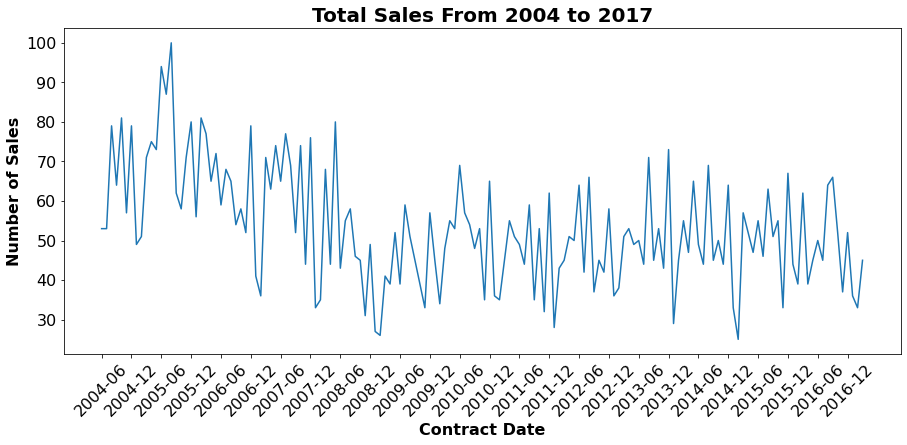

In [5]:
#graph time plot of data to examine vehicle sales yearly/monthly
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(ts['ContractYearMonth'], ts['TotalSales'])
x_ticks = np.arange(0,153,6) #start at index 0, stop at 153, and step up by 6
plt.xticks(x_ticks, rotation = 45)

ax.set_title('Total Sales From 2004 to 2017', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Contract Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Number of Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

We can see that the "ts" dataset has a clear downward trend which suggests that the time series is non-stationary, as we know. However, lets confirm so again in this notebook using the ADFuller test.

## 3.7 Data Modeling

To confirm that the "ts" dataset is non-stationary we will be performing an ADF Test using the following: **The null hypothesis:** the time series is stationary. **The alternative hypothesis:** the time series is stationary, as our test hypothesis.

In [6]:
result = adfuller(ts_sets['TotalSales'].ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.586742
p-value: 0.095768
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


Since the p-value (0.09) is greater than the significance level [0.05] then the null hypothesis is accepted stating the time series is indeed non-stationary and the alternative hypthesis rejected. Therefore, we need to apply differencing to the time series to make it stationary. We will do so by setting the (d) parameter of the ARIMA model to 1.

### 3.6.1 Auto-Regressive Integrated Moving Average (ARIMA) Model

A ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. The 'AR' stands for "autoregression, the 'I' for "integrated, and the 'MA' for "moving average. Each of these components are explicitly specified in the model as a parameter.

The parameters of the ARIMA model are defined as follows: (p) is the number of autoregressive lags, (d) is the order of differencing required to make the series stationary, and (q) is the number of moving average lags. We need to decide the order of each of these parts. To do so, we will use a fuction within the pmdarima library that can do this automatically for us.

In [66]:
#auto diff parameter to make stationary
arima_model = auto_arima(train, start_p=0, start_q=0, test="adf", supress_warnings = True, trace=True)

#Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=916.038, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=865.902, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=853.179, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=914.038, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=854.328, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=854.672, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=854.864, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=852.124, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=852.815, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=853.303, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=863.902, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=853.394, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.421 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -424.062
Date:                Mon, 10 May 2021   AIC                            852.124
Time:                        15:23:54   BIC                            857.451
Sample:                             0   HQIC                           854.283
                                - 107                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8387      0.052    -16.211      0.000      -0.940      -0.737
sigma2       172.7468     30.906      5.589      0.000     112.171     233.322
===================================================================================
Ljung-Box (Q):                      116.85   Jarque-Bera (JB):                 2.66
Prob(Q):                              0.00   Prob(JB):                         0.26
Heteroskedasticity (H):               0.60   Skew:                            -0.04
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the above output we can see that there are 107 observations within the training dataset and the best model fit for the ARIMA model is SARIMAX with the parameters (0,1,1) referring to (p,d,q) respectively. A SARIMAX is a Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors and is an extension of the ARIMA class of models. SARIMAX is for data with trend and/or seasonality.

#### Checking SARIMAX Model Performance Using MAPE

In [69]:
#Predict the future values
valid['predicted'] = arima_model.predict(n_periods = len(valid))
 
def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100
 
print("The MAPE for the SARIMAX model is", MAPE(valid.TotalSales, valid.predicted))

The MAPE for the ARIMA model is 18.577087874870685


<ipython-input-69-620c5980feba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predicted'] = arima_model.predict(n_periods = len(valid))


### 3.6.2 Holt-Winter's Exponential Smoothing Model (Holt-Winter's Method)

A Holt-Winter's Method (a.k.a. Triple Exponential Smoothing Model) extends Holt to allow the forecasting of time series data that has both trend and seasonality. A Holt-Winter's Exponential Smoothing Model subsumes single and double exponential smoothing by the configuration of the nature of the trend (additive, multiplicative, or none) and the nature of the seasonality (additive, multiplicative, or none), as well as any dampening of the trend.

In this section, 
we will develop a framework for grid searching exponential smoothing model hyperparameters for our given univariate time series. 

Running the block of code below is relatively slow given the large amount of data. Model configurations and the RMSE will be printed as the models are evaluated. The top three model configurations and their error will be reported at the end of the run.

In [27]:
#one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    #define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    #fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    #make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

#root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

#split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    #split dataset
    train, test = train_test_split(data, n_test)
    #seed history with training dataset
    history = [x for x in train]
    #step over each time-step in the test set
    for i in range(len(test)):
        #fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        #store forecast in list of predictions
        predictions.append(yhat)
        #add actual observation to history for the next loop
        history.append(test[i])
    #estimate prediction error
    error = measure_rmse(test, predictions)
    return error

#score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    #convert config to a key
    key = str(cfg)
    #show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        #one failure during model validation suggests an unstable config
        try:
            #never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    #check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

#grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        #execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    #remove empty results
    scores = [r for r in scores if r[1] != None]
    #sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

#create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    #define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    #create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

if __name__ == '__main__':
    #load dataset
    series = read_csv('../data/processed/TotalSales.csv', header=0, index_col=0)
    data = series.values
    #data split
    n_test = 47
    #model configs / seasonal could be 0, 3, 6, or 12 months
    cfg_list = exp_smoothing_configs(seasonal=[0,3,6,12])
    #grid search
    scores = grid_search(data[:,0], cfg_list, n_test)
    print('done')
    #list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)


KeyboardInterrupt: 

We can see that the best result out of the top three is an RMSE of about 7.65 degrees with the following configuration:

**Trend:** Multiplicative,
**Damped:** True,
**Seasonal:** Additive,
**Seasonal Periods:** 12,
**Box-Cox Transform:** True,
**Remove Bias:** False

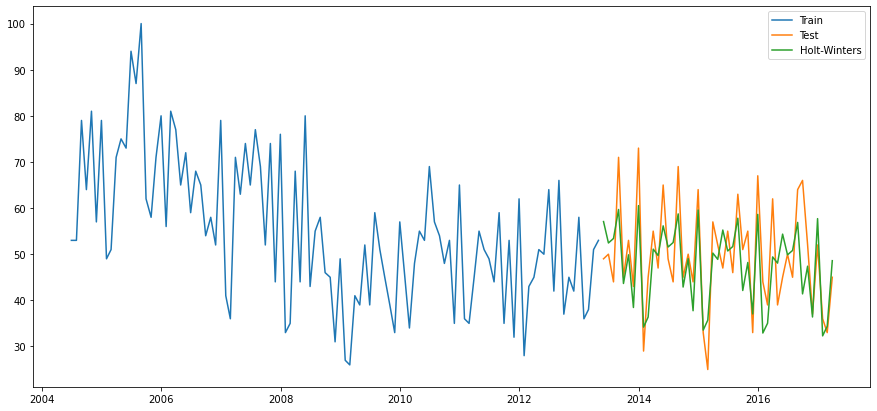

In [76]:
#once correct params are known from the output above then enter those params here.
rcParams['figure.figsize'] = 15, 7

df = read_csv('../data/processed/TotalSales.csv')
df.index = pd.date_range(start='2004-06', periods=154, freq='M')
df = df.drop(columns=['ContractYearMonth'])
df.index.freq = 'M'
train, test = df[:int(0.7*(len(df)))], df[int(0.7*(len(df))):]
# model = ExponentialSmoothing(params).fit()
model = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=12, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=True, remove_bias=False)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

#plot prediction using model
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best');

We will now calculate MAPE to check to accuracy of our model.

#### Checking Holt-Winter's Method Performance Using MAPE

In [77]:
print("The MAPE for the Holt-Winter's Method is", MAPE(test, pred))

The MAPE for the Holt-Winter's Method is 24.35746755574687


# CONCLUSION

The performance of the models on the test data is summarized below:
1. ARIMA Model: MAPE of 18.6%
2. Holt-Winter's Method: MAPE of 24.4%

So far, the ARIMA model has outperformed the other model by producing the lowest MAPE of 18.6%.

# Save Data